In [14]:
import sys
sys.executable

'C:\\Users\\jthqw\\myenv\\Scripts\\python.exe'

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from raytracing import *
from tdwg.lib.simulation import *
from tdwg.lib.DMD_patterns import generate_curved_waveguide, generate_spotty_image, resX, resY, generate_horizontal_grating

In [9]:
from IPython.core.debugger import set_trace
from importlib import reload

def crazy_reload(package_string):
    exec(rf"import {package_string}")
    exec(rf"reload({package_string})")
    exec(rf"from {package_string} import *")

## Set simulation parameters

DeprecationWarning [in <>]: invalid escape sequence '\m'
DeprecationWarning [in <>]: invalid escape sequence '\m'
DeprecationWarning [in <>]: invalid escape sequence '\m'
DeprecationWarning [in <>]: invalid escape sequence '\m'
DeprecationWarning [in 3855163304.py]: invalid escape sequence '\m'
DeprecationWarning [in 3855163304.py]: invalid escape sequence '\m'
DeprecationWarning [in 3855163304.py]: invalid escape sequence '\m'
DeprecationWarning [in 3855163304.py]: invalid escape sequence '\m'


TypeError: WaveguideSimulation.__init__() got an unexpected keyword argument 'Ly'

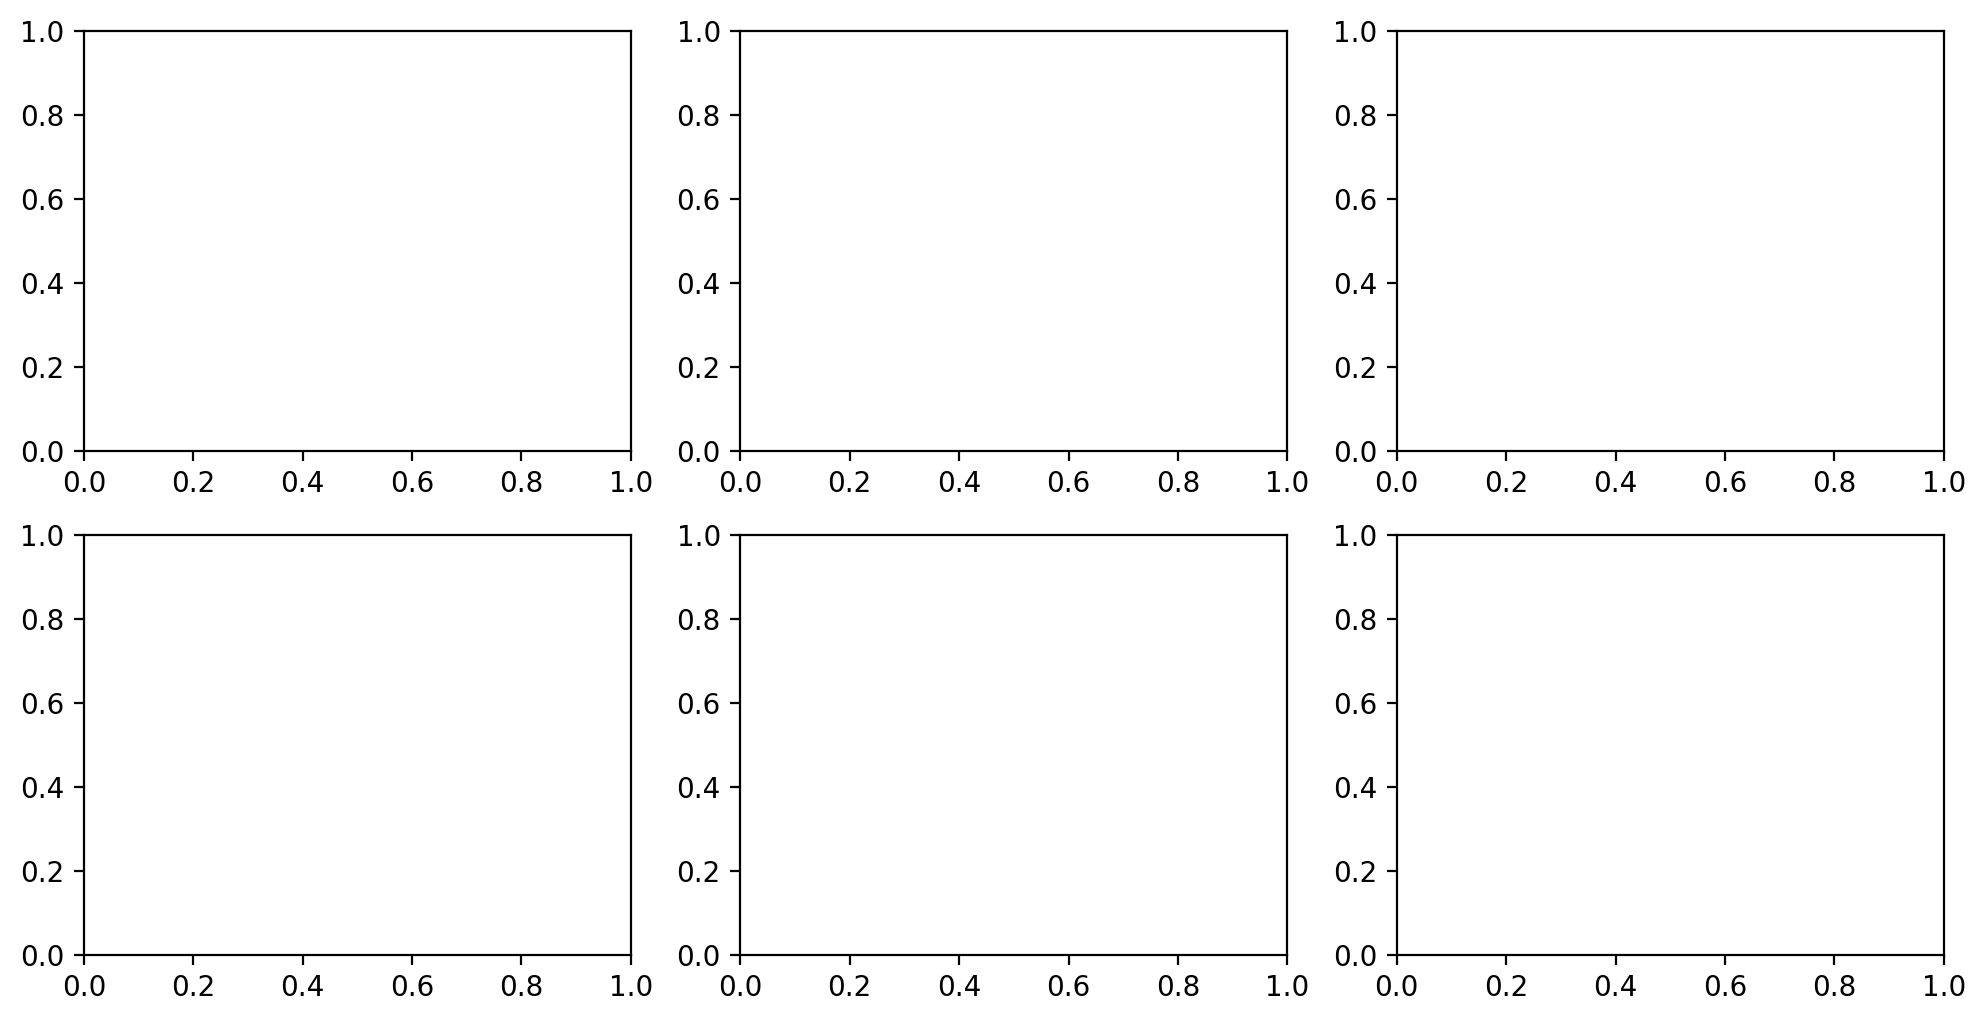

In [11]:
for electrode_length in [25e3, 50e3, 100e3]:
    fig, axs = plt.subplots(2, 3, figsize = [12,6], dpi = 200)
    i = 0
    for scale_factor in [1, 4]:
        for carrier_diffusion_length in [1, 10, 50]:
            # buttcoupling parameters (lengths in MILLIMETERS)
            angle_deg = 0 #angle between waveguide facet normal and input beam in degree
            w0 = 30 # beam waist (um)
            #rayleigh_range = beam_waist_to_rayleigh_range(w0)
            rayleigh_range = 0

            # chip parameters (lengths in MICROMETERS)
            input_length = 0e3 # distance between input facet and electrode (um)
            output_length = 0e3 # distance between output facet and electrode (um)
            # electrode_length = 30e3 # length of electrode (um)
            n_wg = 2.2 # effective index of waveguide
            delta_n_val= 1.e-3 # (effective) index modulation in bright regions
            pixel_size = electrode_length / (scale_factor*resY)

            # simulation parameters
            Lz = (input_length+electrode_length+output_length) # length of waveguide in microns
            Ly = 800*4 # width of simulated waveguide area in microns 
            Ny = 2**11 
            dz = 1.55 / delta_n_val / 100

            # bent waveguide parameters (lengths in MICROMETERS)
            r = scale_factor * 3e4 # radius of curvature (DMD pixels)
            d_wg = int(scale_factor * 100e3 / electrode_length) # waveguide width (DMD pixels)
            # carrier_diffusion_length = 50 # carrier diffusion length (um)
            entrance_point = 500 # DMD pixel at which waveguide begins

            # create waveguide simulation object
            wg = WaveguideSimulation(Ly=Ly, Ny=Ny, Lz=Lz, dz=dz, delta_n_val=delta_n_val)

            # create gaussian input beam according to buttcoupling setup lenses
            input_beam = torch.from_numpy(gaussian_beam_from_q_parameter(wg, 1j*rayleigh_range, angle_deg, center_um = 0))
            wg.set_input_beam(input_beam)
            
            ### compute MTF
            # create DMD-induced refractive index pattern on waveguide
            DMDpattern = torch.from_numpy(generate_horizontal_grating(scale_factor, resX = scale_factor*resX, resY = scale_factor*resY)).float()
            # resize DMD pattern to simulation area
            delta_n = DMDpattern_to_simulation_pattern(wg, DMDpattern, electrode_length, center_pixel=entrance_point)
            # apply carrier diffusion length
            delta_n = wg.smoothen_spatial_map(delta_n, carrier_diffusion_length)/delta_n_val

            delta_n_slice = delta_n[0, int(delta_n.shape[1] * 1/4) : int(delta_n.shape[1] * 3/4)]
            # plt.plot(delta_n_slice)
            mtf = delta_n_slice.max() - delta_n_slice.min()
            ###

            # create DMD-induced refractive index pattern on waveguide
            DMDpattern = torch.from_numpy(generate_curved_waveguide(d_wg, r, entrance_point = entrance_point-0.5, resX = scale_factor*resX, resY = scale_factor*resY)).float()
            # resize DMD pattern to simulation area
            delta_n = DMDpattern_to_simulation_pattern(wg, DMDpattern, electrode_length, center_pixel=entrance_point)
            # apply carrier diffusion length
            delta_n = wg.smoothen_spatial_map(delta_n, carrier_diffusion_length)
            wg.delta_n = delta_n

            # run simulations with voltage on and off
            data_V_on = wg.run_simulation()
            # data_V_off = run_no_voltage_simulation(wg)

            inp_I = (torch.abs(data_V_on[0])).cpu()
            out_on_I = (torch.abs(data_V_on[-1])).cpu()
            # out_off_I = (torch.abs(data_V_off[-1])).cpu()

        #     plt.figure(dpi=100)
        #     plt.title(f'$\Delta n=${delta_n_val:.1e},\n\
        #     carrier diffusion length = {carrier_diffusion_length:.0f}$\mu$m\n\
        #     pixel size = {pixel_size:.0f}$\mu$m'
        #              )
        #     plt.plot(wg.y_axis, out_on_I, label="output E on")
        #     plt.plot(wg.y_axis, inp_I, label="input E on")
        #     # plt.plot(wg.y_axis, out_off_I, label="output E off")

        #     plt.xlabel("x (um)")
        #     plt.ylabel("E field (a.u.)")
        #     plt.legend()
        #     plt.show()

            plt.sca(axs.flatten()[i])
            plt.title(
            f'pixel size = {pixel_size:.0f}$\mu$m\n\
            $L_D=${carrier_diffusion_length:.0f}$\mu$m / MTF = {mtf*100:.1f}%\
            ')

            plt.pcolormesh(wg.z_list/1e3, wg.y_axis, torch.abs((data_V_on).cpu()).T, cmap="inferno")
            # plt.colorbar()
            plt.pcolormesh(wg.z_axis[::10]/1e3, wg.y_axis[::10], wg.delta_n.T[::10, ::10], cmap="binary_r", alpha=0.3)
            plt.ylim(-400, 1600)

            plt.xlabel("z (mm)")
            plt.ylabel("y (um)")
            i += 1
    # plt.suptitle(f'Magnification = {electrode_length / 14e3:.1f}')
    plt.tight_layout()
    plt.savefig(f'{electrode_length/1e3}mm.png')

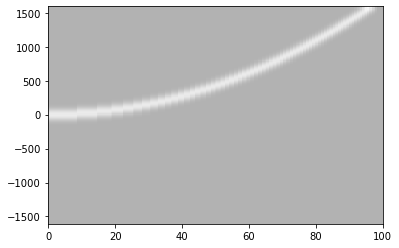

In [54]:
plt.pcolormesh(wg.z_axis[::10]/1e3, wg.y_axis[::10], wg.delta_n.T[::10, ::10], cmap="binary_r", alpha=0.3)

In [58]:
delta_n.max()

tensor(0.0009)

tensor(201.3120)
tensor(201.3120)


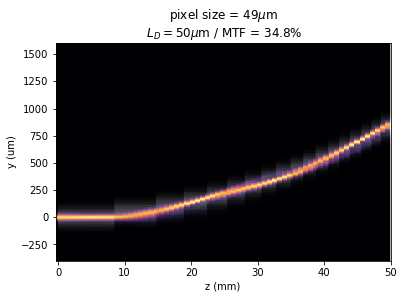

In [65]:
for electrode_length in [50e3]:
    for scale_factor in [1]:
        for carrier_diffusion_length in [50]:
            # buttcoupling parameters (lengths in MILLIMETERS)
            angle_deg = 0 #angle between waveguide facet normal and input beam in degree
            w0 = 30 # beam waist (um)
            rayleigh_range = beam_waist_to_rayleigh_range(w0)

            # chip parameters (lengths in MICROMETERS)
            input_length = 0e3 # distance between input facet and electrode (um)
            output_length = 0e3 # distance between output facet and electrode (um)
            # electrode_length = 30e3 # length of electrode (um)
            n_wg = 2.2 # effective index of waveguide
            delta_n_val= 1.e-3 # (effective) index modulation in bright regions
            pixel_size = electrode_length / (scale_factor*resY)

            # simulation parameters
            Lz = (input_length+electrode_length+output_length) # length of waveguide in microns
            Ly = 800*4 # width of simulated waveguide area in microns 
            Ny = 2**11 
            dz = 1.55 / delta_n_val / 100

            # bent waveguide parameters (lengths in MICROMETERS)
            r = scale_factor * 3e4 # radius of curvature (DMD pixels)
            d_wg = int(scale_factor * 100e3 / electrode_length) # waveguide width (DMD pixels)
            # carrier_diffusion_length = 50 # carrier diffusion length (um)
            entrance_point = 500 # DMD pixel at which waveguide begins

            # create waveguide simulation object
            wg = WaveguideSimulation(Ly=Ly, Ny=Ny, Lz=Lz, dz=dz, delta_n_val=delta_n_val)

            # create gaussian input beam according to buttcoupling setup lenses
            input_beam = torch.from_numpy(gaussian_beam_from_q_parameter(wg, 1j*rayleigh_range, angle_deg, center_um = 0))
            wg.set_input_beam(input_beam)
            
            ### compute MTF
            # create DMD-induced refractive index pattern on waveguide
            DMDpattern = torch.from_numpy(generate_horizontal_grating(2*scale_factor, resX = scale_factor*resX, resY = scale_factor*resY)).float()
            # resize DMD pattern to simulation area
            delta_n = DMDpattern_to_simulation_pattern(wg, DMDpattern, electrode_length, center_pixel=entrance_point)
            # apply carrier diffusion length
            delta_n = wg.smoothen_spatial_map(delta_n, carrier_diffusion_length)/delta_n_val

            delta_n_slice = delta_n[0, int(delta_n.shape[1] * 1/4) : int(delta_n.shape[1] * 3/4)]
            # plt.plot(delta_n_slice)
            mtf = delta_n_slice.max() - delta_n_slice.min()
            ###

            # create DMD-induced refractive index pattern on waveguide
            DMDpattern = torch.from_numpy(generate_curved_waveguide(d_wg, r, entrance_point = entrance_point-0.5, resX = scale_factor*resX, resY = scale_factor*resY)).float()
            # resize DMD pattern to simulation area
            delta_n = DMDpattern_to_simulation_pattern(wg, DMDpattern, electrode_length, center_pixel=entrance_point)
            print(delta_n.sum())
            # apply carrier diffusion length
            delta_n = wg.smoothen_spatial_map(delta_n, carrier_diffusion_length)
            print(delta_n.sum())
            wg.delta_n = delta_n

            # run simulations with voltage on and off
            data_V_on = wg.run_simulation()
            # data_V_off = run_no_voltage_simulation(wg)

            inp_I = (torch.abs(data_V_on[0])).cpu()
            out_on_I = (torch.abs(data_V_on[-1])).cpu()
            # out_off_I = (torch.abs(data_V_off[-1])).cpu()

        #     plt.figure(dpi=100)
        #     plt.title(f'$\Delta n=${delta_n_val:.1e},\n\
        #     carrier diffusion length = {carrier_diffusion_length:.0f}$\mu$m\n\
        #     pixel size = {pixel_size:.0f}$\mu$m'
        #              )
        #     plt.plot(wg.y_axis, out_on_I, label="output E on")
        #     plt.plot(wg.y_axis, inp_I, label="input E on")
        #     # plt.plot(wg.y_axis, out_off_I, label="output E off")

        #     plt.xlabel("x (um)")
        #     plt.ylabel("E field (a.u.)")
        #     plt.legend()
        #     plt.show()

            plt.title(
            f'pixel size = {pixel_size:.0f}$\mu$m\n\
            $L_D=${carrier_diffusion_length:.0f}$\mu$m / MTF = {mtf*100:.1f}%\
            ')

            plt.pcolormesh(wg.z_list/1e3, wg.y_axis, torch.abs((data_V_on).cpu()).T, cmap="inferno")
            # plt.colorbar()
            plt.pcolormesh(wg.z_axis[::10]/1e3, wg.y_axis[::10], wg.delta_n.T[::10, ::10], cmap="binary_r", alpha=0.3)
            plt.ylim(-400, 1600)

            plt.xlabel("z (mm)")
            plt.ylabel("y (um)")

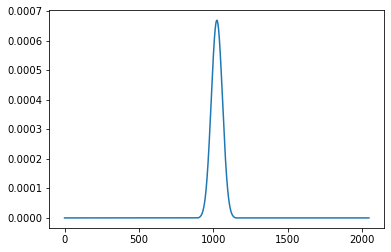

In [66]:
plt.plot(wg.delta_n[0])